# 数据加载与初步探索

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
import xgboost as xgb
from sklearn.svm import SVC
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# 加载数据
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
print(train_df.head())

# 查看缺失值
# print(train_df.isnull().sum())
# # Age, Cabin, Embarked 存在缺失值
# print(test_df.isnull().sum())
# # Age, Fare, Cabin存在缺失值

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


# 特征工程

In [3]:
## 缺失值处理

### 1.数值特征：中位数插补
age_imputer = SimpleImputer(strategy='median')
train_df.loc[:,"Age"] = age_imputer.fit_transform(train_df[["Age"]])
test_df.loc[:,"Age"] = age_imputer.transform(test_df[["Age"]])

### 2.类别特征Embarked：众数插补
embarked_mode = train_df["Embarked"].mode()[0]
train_df.loc[:,"Embarked"] = train_df['Embarked'].fillna(embarked_mode)
test_df.loc[:,"Embarked"] = test_df['Embarked'].fillna(embarked_mode)

### 3.类别特征cabin缺失过多，用“Unknown”标记
train_df.loc[:,"Cabin"] = train_df['Cabin'].fillna('Unknown')
test_df.loc[:,"Cabin"] = test_df['Cabin'].fillna('Unknown')

### 4. 测试集Fare缺失值: 中位数插补
fare_imputer = SimpleImputer(strategy='median')
train_df.loc[:,'Fare'] = fare_imputer.fit_transform(train_df[['Fare']])
test_df.loc[:,'Fare'] = fare_imputer.transform(test_df[['Fare']])

In [4]:
# # 手动分箱效果不如xgboost自动分箱
# # 训练集[0, 22, 28, 35, 80]数28，测试集[0, 23, 26, 37.75, 76]
# # print(train_df['Age'].describe(), test_df['Age'].describe())
# bins = [0, 23, 28, 35, np.inf] 
# labels = ['0-23', '23-28', '28-35', '35+']
# train_df['AgeGroup'] = pd.cut(train_df['Age'], bins = bins, labels = labels, right=False)
# test_df['AgeGroup'] = pd.cut(test_df['Age'], bins = bins, labels = labels, right=False)

In [5]:
## 类别特征编码

### 1.二分类特征Sex：标签编码
sex_label = LabelEncoder()
train_df.loc[:,"Sex_Encoded"] = sex_label.fit_transform(train_df[["Sex"]])
test_df.loc[:,"Sex_Encoded"] = sex_label.transform(test_df[["Sex"]])

### 2.多分类特征Embarked：独热编码，drop_first避免多重共线性
train_df = pd.get_dummies(train_df, columns = ['Embarked'], drop_first=True)
test_df = pd.get_dummies(test_df, columns = ['Embarked'], drop_first=True)

### 3.Cabin特征（首字母代码客舱等级）：提取首字母
train_df.loc[:, 'Cabin_prefix'] = train_df['Cabin'].str[0]
test_df.loc[:, 'Cabin_prefix'] = test_df['Cabin'].str[0]
train_df = pd.get_dummies(train_df, columns = ['Cabin_prefix'], drop_first=True)
test_df = pd.get_dummies(test_df, columns = ['Cabin_prefix'], drop_first=True)
# 对齐训练集和测试集的特征, 避免有的值没有出现训练集和测试集的特征不匹配问题
train_df, test_df = train_df.align(test_df, join='left', axis = 1, fill_value = 0)

# ### 4.Age group
# train_df = pd.get_dummies(train_df, columns = ['AgeGroup'], drop_first=True)
# test_df = pd.get_dummies(test_df, columns = ['AgeGroup'], drop_first=True)

/Users/yilia/code/pythonProject/venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yilia/code/pythonProject/venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [6]:
## 构造特征
### 1.家庭规模：SibSp+Parch+1（自己）
train_df.loc[:, 'FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df.loc[:, 'FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

### 2.头衔提取：从Name中提取Mr/Miss/Mrs等
train_df.loc[:, 'Title'] = train_df['Name'].str.extract("([A-Za-z]+)\.", expand=False)
test_df.loc[:, 'Title'] = test_df['Name'].str.extract("([A-Za-z]+)\.", expand=False)
# print(train_df['Title'].value_counts())
# print(test_df['Title'].value_counts())

### 3.合并稀有头衔(频率小于10)为Rare
rare_titles = train_df['Title'].value_counts()[train_df['Title'].value_counts()<10].index
train_df.loc[train_df['Title'].isin(rare_titles), 'Title'] = 'Rare'
test_df.loc[test_df['Title'].isin(rare_titles), 'Title'] = 'Rare'

train_df = pd.get_dummies(train_df, columns=['Title'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Title'], drop_first=True)
train_df, test_df = train_df.align(test_df, join='left', axis = 1, fill_value = 0)

# ### 4.提取儿童和老人
train_df['Is_child'] = (train_df['Age']<=12).astype(int)
train_df['Is_elder'] = (train_df['Age']>60).astype(int)
test_df['Is_child'] = (test_df['Age']<=12).astype(int)
test_df['Is_elder'] = (test_df['Age']>60).astype(int)
features = ['Pclass', 'Age', 'Is_child', 'Is_elder','Fare', 'Sex_Encoded', 'Embarked_Q', 'Embarked_S'] + [col for col in train_df.columns if 'Cabin_prefix' in col or 'Title' in col]


# 选择特征与模型训练

In [7]:
# print(train_df.columns)
features = ['Pclass', 'Age', 'Is_child', 'Is_elder','Fare', 'Sex_Encoded', 'Embarked_Q', 'Embarked_S'] + [col for col in train_df.columns if 'Cabin_prefix' in col or 'Title' in col]
# 确保特征在测试集中存在
features = [f for f in features if f in test_df.columns]
print(features)

['Pclass', 'Age', 'Is_child', 'Is_elder', 'Fare', 'Sex_Encoded', 'Embarked_Q', 'Embarked_S', 'Cabin_prefix_B', 'Cabin_prefix_C', 'Cabin_prefix_D', 'Cabin_prefix_E', 'Cabin_prefix_F', 'Cabin_prefix_G', 'Cabin_prefix_T', 'Cabin_prefix_U', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']


In [8]:
X = train_df[features]
y = train_df['Survived']
X_test = test_df[features]

In [9]:
## 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42)

In [10]:
## 选择模型 - 随机森林
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
## 交叉验证
rf_cv_score = cross_val_score(rf_model, X, y, cv=5).mean()
print(f"交叉验证准确率:{rf_cv_score:4f}")

交叉验证准确率:0.812560


In [11]:
## 选择模型 -xgboost
xgb_model = xgb.XGBClassifier(n_estimators = 100, random_state=42)
xgb_model.fit(X_train, y_train)
## 交叉验证
xgb_cv_score = cross_val_score(xgb_model, X, y, cv=5).mean()
print(f"交叉验证准确率:{xgb_cv_score:4f}")

交叉验证准确率:0.820413


In [12]:
## 选择模型 -svm
svm_model = xgb.XGBClassifier(n_estimators = 100, random_state=42)
svm_model.fit(X_train, y_train)
## 交叉验证
svm_cv_score = cross_val_score(svm_model, X, y, cv=5).mean()
print(f"交叉验证准确率:{xgb_cv_score:4f}")

交叉验证准确率:0.820413


In [13]:
## 选择模型 -svc
svc_model = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)
svc_model.fit(X_train, y_train)
## 交叉验证
svc_cv_score = cross_val_score(svc_model, X, y, cv=5).mean()
print(f"交叉验证准确率:{svc_cv_score:4f}")

交叉验证准确率:0.672381


In [14]:
## 选择模型- lr
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_cv_score = cross_val_score(lr_model, X, y, cv=5).mean()
print(f"交叉验证准确率:{lr_cv_score:4f}")

交叉验证准确率:0.800257


/Users/yilia/code/pythonProject/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yilia/code/pythonProject/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/st

In [15]:
# ## lightgbm
# lgbm_model = lgbm.LGBMClassifier(n_estimators=100,random_state=42)
# lgbm_model.fit(X_train, y_train)

In [16]:
# ## 交叉验证
# lgbm_cv_score = cross_val_score(lgbm_model, X, y, cv=5).mean()
# print(f"交叉验证准确率:{lgbm_cv_score:4f}")

# 调参

In [17]:
## 网格搜索-rf
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300, 400, 500],     # 树的数量
    'max_depth': [5, 7, 9],             # 树的深度
}

grid_search_rf = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid_rf, 
    cv=5, 
    scoring='accuracy', 
    verbose=1,   # 设置为 1 可以看到搜索进度
    n_jobs=-1    # 再次强调，Mac 上用 -1 开启多核加速
)

# 4. 执行搜索
grid_search_rf.fit(X_train, y_train)

# 5. 输出结果
print(f"最佳参数: {grid_search_rf.best_params_}")
print(f"最佳得分: {grid_search_rf.best_score_:.4f}")

best_rf = grid_search_rf.best_estimator_
rf_importances = best_rf.feature_importances_
 
feature_importances = pd.DataFrame([features, rf_importances])
print(feature_importances)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
最佳参数: {'max_depth': 7, 'n_estimators': 400}
最佳得分: 0.8371
         0         1         2         3         4            5           6   \
0    Pclass       Age  Is_child  Is_elder      Fare  Sex_Encoded  Embarked_Q   
1  0.104166  0.105065  0.017817  0.004965  0.146193     0.197061    0.011132   

           7               8               9               10              11  \
0  Embarked_S  Cabin_prefix_B  Cabin_prefix_C  Cabin_prefix_D  Cabin_prefix_E   
1    0.022692        0.011502        0.007006        0.007253        0.012942   

               12              13              14              15          16  \
0  Cabin_prefix_F  Cabin_prefix_G  Cabin_prefix_T  Cabin_prefix_U  Title_Miss   
1        0.003247        0.002821        0.000202        0.041776    0.046796   

         17         18          19  
0  Title_Mr  Title_Mrs  Title_Rare  
1  0.191416   0.058432    0.007515  


In [18]:
## 网格搜索-xgb
param_grid_xgb = {
    'n_estimators': [50, 100, 200],     # 树的数量
    'max_depth': [1, 3, 5, 7],             # 树的深度
    'learning_rate': [0.01, 0.1, 0.2],  # 学习率
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]             # 训练每棵树时使用的样本比例
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid_xgb, 
    cv=5, 
    scoring='accuracy', 
    verbose=1,   # 设置为 1 可以看到搜索进度
    n_jobs=-1    # 再次强调，Mac 上用 -1 开启多核加速
)

# 4. 执行搜索
grid_search_xgb.fit(X_train, y_train)

# 5. 输出结果
print(f"最佳参数: {grid_search_xgb.best_params_}")
print(f"最佳得分: {grid_search_xgb.best_score_:.4f}")

best_xgb = grid_search_xgb.best_estimator_ # max_depth = 3, learning_rate = 0.1, n_estimators=100
importances = best_xgb.feature_importances_ 
feature_importances = pd.DataFrame([features, importances])
print(feature_importances)
# xgb.plot_importance(best_xgb)
# plt.show()

Fitting 5 folds for each of 180 candidates, totalling 900 fits
最佳参数: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
最佳得分: 0.8441
         0         1         2         3         4            5           6   \
0    Pclass       Age  Is_child  Is_elder      Fare  Sex_Encoded  Embarked_Q   
1  0.101044  0.020671       0.0       0.0  0.030709     0.130833    0.021212   

           7               8               9               10              11  \
0  Embarked_S  Cabin_prefix_B  Cabin_prefix_C  Cabin_prefix_D  Cabin_prefix_E   
1    0.030952        0.018333        0.019914        0.024633        0.035187   

               12              13              14              15          16  \
0  Cabin_prefix_F  Cabin_prefix_G  Cabin_prefix_T  Cabin_prefix_U  Title_Miss   
1             0.0             0.0             0.0        0.041218    0.016837   

         17         18          19  
0  Title_Mr  Title_Mrs  Title_Rare  
1  0.429145    0.02989    0.049423  


In [43]:
## 网格搜索-svc（涉及svc比较慢
param_grid_svc = [
    # 第一组：针对 RBF 核，搜索 C 和 gamma
  {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.001]},
  
  # 第二组：针对线性核，只搜索 C
  {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}
]

grid_search_svc = GridSearchCV(
    estimator=svc_model, 
    param_grid=param_grid_svc, 
    cv=5, 
    scoring='accuracy', 
    verbose=1,   # 设置为 1 可以看到搜索进度
    n_jobs=-1    # 再次强调，Mac 上用 -1 开启多核加速
)

# 4. 执行搜索
grid_search_svc.fit(X_train, y_train)

# 5. 输出结果
print(f"最佳参数: {grid_search_svc.best_params_}")
print(f"最佳得分: {grid_search_svc.best_score_:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
最佳参数: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
最佳得分: 0.7907


# 集成

In [20]:
# 创建集成模型（涉及svc比较慢
eclf = VotingClassifier(
    estimators=[('rf', grid_search_rf), ('xgb', grid_search_xgb)
                # , ('svc', grid_search_svc),
               ],
    voting='soft',  # 推荐使用 soft
    # weights=[2, 3]
)

eclf.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits


,estimators,"[('rf', ...), ('xgb', ...)]"
,voting,'soft'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,n_estimators,400
,criterion,'gini'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1


In [21]:
eclf_cv_score = cross_val_score(eclf, X, y, cv=5).mean()
print(f"交叉验证准确率:{eclf_cv_score:4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 180 candidates, totalling 900 fits
交叉验证准确率:0.833902


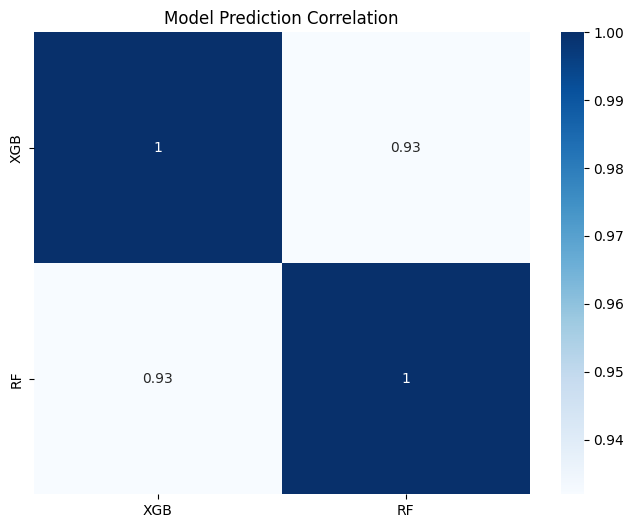

In [23]:
import seaborn as sns

# 获取各模型对训练集的预测结果
pred_xgb = best_xgb.predict(X_train)
pred_rf = best_rf.predict(X_train)
# pred_svc = best_svc.predict(X_train)

# 构建相关性矩阵
all_preds = pd.DataFrame({
    'XGB': pred_xgb,
    'RF': pred_rf,
    # 'SVC': pred_svc
})

# 绘图
plt.figure(figsize=(8, 6))
sns.heatmap(all_preds.corr(), annot=True, cmap='Blues')
plt.title("Model Prediction Correlation")
plt.show()
# 提示： 如果相关性系数在 0.7~0.85 之间，说明集成效果会非常明显；如果高于 0.95，说明模型太相似了。

In [24]:
final_est = LogisticRegression()
estimators = [
    ('rf', RandomForestClassifier(n_estimators=400, max_depth=7, random_state=42)),
    ('xgb', xgb.XGBClassifier(learning_rate = 0.1, max_depth = 3, n_estimators =100, subsample = 0.8, random_state=42))
    # ,
    # SVC 建议配合 StandardScaler 使用
    # ('svc', make_pipeline(StandardScaler(), SVC(probability=True, C=100, gamma = 0.001, kernel = 'rbf')))
]
# 3. 组装两层模型
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_est,
    cv=5,            # 在第一层和第二层之间使用5折交叉验证生成预测值
    stack_method='predict_proba' # 使用概率作为第二层的特征
)

# 4. 训练与评估
stacking_model.fit(X_train, y_train)
print(f"Stacking 训练集准确率: {stacking_model.score(X_train, y_train):.4f}")

stacking_cv_score = cross_val_score(stacking_model, X, y, cv=5).mean()
print(f"交叉验证准确率:{stacking_cv_score:4f}")

Stacking 训练集准确率: 0.9017
交叉验证准确率:0.837273


In [25]:
y_pred_stacking = grid_search_xgb.predict(X_test)
Submission_df = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived":y_pred_stacking})
Submission_df.to_csv("titanic_submission_stacking.csv", index=False)

# 变量重要性

In [ ]:
# import shap
# # 1. 确认模型训练时到底用了哪些特征
# trained_features = best_xgb.feature_names_in_
# print("模型实际训练时使用的特征：", trained_features)

# # 2. 准备对应的测试数据（严格对齐列名和顺序）
# X_test_aligned = X_val[trained_features].iloc[:20, :]

# # 3. 重新计算 SHAP
# model_func = lambda x: best_xgb.predict_proba(x)
# explainer = shap.KernelExplainer(model_func, shap.sample(X_train[trained_features], 50))
# shap_values = explainer.shap_values(X_test_aligned, nsamples=100)

# # 提取生存类别的 SHAP 矩阵
# val_matrix = np.array(shap_values[1] if isinstance(shap_values, list) else shap_values)

# # 2. 计算每个特征的影响力绝对值总和
# impact_sum = np.abs(val_matrix).sum(axis=0)

# # 3. 打印出来看
# for name, impact in zip(X_val.columns, impact_sum):
#     val = impact[0] if isinstance(impact, np.ndarray) else impact
#     print(f"特征: {name:<15} | 影响力总和: {float(val):.6f}")


In [64]:
# y_pred_xgb = grid_search_xgb.predict(X_test)
# Submission_df = pd.DataFrame({"PassengerId": test_df["PassengerId"], "Survived":y_pred_xgb})
# Submission_df.to_csv("titanic_submission.csv", index=False)